In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import wfdb
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset

In [11]:
# Define paths
DATASET_PATH = '/group/avfedor-g00/datasets/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
metadata_path = os.path.join(DATASET_PATH, 'ptbxl_database.csv')
agg_path = os.path.join(DATASET_PATH, 'scp_statements.csv')

In [12]:
scp_statements = pd.read_csv('./scp_statements.csv')

In [13]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
5,6,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,...,True,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr
6,7,16193.0,54.0,0,NaN,83.0,2.0,0.0,CS-12 E,1984-11-28 13:32:22,...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00007_lr,records500/00000/00007_hr
7,8,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,...,True,", II,AVF",", I-AVF,",NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr
8,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr
9,10,9456.0,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1984-12-12 14:12:46,...,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00010_lr,records500/00000/00010_hr


In [14]:
from tqdm import tqdm
from skimage import io, transform
from torchvision import transforms, utils

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [15]:
# Define function to load raw data
def load_raw_data(df, sampling_rate, dataset_path):
    # Determine the filename column based on the sampling rate
    filenames = df.filename_lr if sampling_rate == 100 else df.filename_hr
    print (len(filenames))
    # Load the ECG signals
    data = [wfdb.rdsamp(os.path.join(dataset_path, filename))[0] for filename in tqdm(filenames)]
    return np.array(data)

In [16]:
# Load and convert annotation data
sampling_rate = 100
Y = pd.read_csv(metadata_path, index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [17]:
y_dic = Y.scp_codes.values[0]
print (y_dic)

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}


In [18]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, DATASET_PATH)

21799


100%|██████████| 21799/21799 [01:38<00:00, 221.38it/s]


In [19]:
agg_df = pd.read_csv('./scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [20]:
agg_df.columns

Index(['description', 'diagnostic', 'form', 'rhythm', 'diagnostic_class',
       'diagnostic_subclass', 'Statement Category',
       'SCP-ECG Statement Description', 'AHA code', 'aECG REFID', 'CDISC Code',
       'DICOM Code'],
      dtype='object')

In [21]:
# Define function to aggregate diagnostic classes directly from metadata
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [22]:
# Apply diagnostic superclass (using the 'diagnostic_class' from metadata)
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [23]:
Y['diagnostic_superclass'][:5]

ecg_id
1    [NORM]
2    [NORM]
3    [NORM]
4    [NORM]
5    [NORM]
Name: diagnostic_superclass, dtype: object

In [24]:
Y['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[CD, MI]               1297
[HYP, STTC]             781
[MI, STTC]              599
[HYP]                   535
[CD, STTC]              471
[]                      411
[NORM, CD]              407
[HYP, MI, STTC]         361
[HYP, CD]               300
[CD, MI, STTC]          223
[HYP, CD, STTC]         211
[HYP, MI]               183
[HYP, CD, MI, STTC]     156
[HYP, CD, MI]           117
[NORM, STTC]             28
[NORM, CD, STTC]          5
[HYP, NORM, CD]           2
[HYP, NORM]               2
[HYP, NORM, MI, CD]       1
Name: count, dtype: int64

In [25]:
import torch
import torch.nn.functional as F

all_labels = ['NORM', 'CD', 'MI', 'HYP', 'STTC']

label_to_index = {label: idx for idx, label in enumerate(all_labels)}

indices = [[label_to_index[label] for label in item] for item in Y['diagnostic_superclass']]

num_classes = len(all_labels)
one_hot_encoded = [F.one_hot(torch.tensor(idx_list, dtype=torch.long), num_classes=num_classes).sum(dim=0).float() for idx_list in indices]

In [26]:
print(one_hot_encoded[62])

tensor([0., 0., 1., 0., 0.])


In [27]:
Y['diagnostic_superclass'] = one_hot_encoded

In [28]:
Y_filtered = Y['diagnostic_superclass']

In [31]:
val_fold = 9
test_fold = 10

train_idx = ~(Y.strat_fold.isin([val_fold, test_fold]))
val_idx = (Y.strat_fold == val_fold)
test_idx = (Y.strat_fold == test_fold)

len(train_idx)

21799

In [ ]:
X_train = X[train_idx]
Y_train = Y_filtered[train_idx]
X_val = X[val_idx]
Y_val = Y_filtered[val_idx]
X_test = X[test_idx]
Y_test = Y_filtered[test_idx]

In [25]:
from torch.utils.data import Dataset, DataLoader

class ECG_Dataset_Int(Dataset):

    def __init__(self, ecg_data, labels, transform=None):
        self.ecg_data = ecg_data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.ecg_data)

    def __getitem__(self, idx):
        try:
            if torch.is_tensor(idx):
                idx = idx.tolist()
    
            ecg_signal = self.ecg_data[idx]
            label = self.labels.iloc[idx]
    
            if self.transform:
                sample = self.transform((ecg_signal, label))
                ecg_signal = sample['ecg']
                label = sample['label']
    
            return ecg_signal, label
        except IndexError as e:
            print(f"IndexError: {e} - Index out of bounds: {idx}")
            raise  # Re-raise the exception after logging

In [ ]:
import torch
import torch.nn.functional as F

class ToTensorInt(object):
    def __call__(self, sample):
        ecg_signal, label = sample
        
        ecg_signal_tensor = torch.tensor(ecg_signal, dtype=torch.float32)
        label_tensor = label
        
        return {'ecg': ecg_signal_tensor, 'label': label_tensor}

In [27]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_sampler(indices):
    return SubsetRandomSampler(indices)

test_indices1 = list(range(17084)) 
test_indices2 = list(range(2158))

batch_size = 4
trainset = ECG_Dataset_Int(ecg_data=X_train, labels=Y_train, transform=transforms.Compose([ToTensorInt()]))
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, sampler=get_sampler(test_indices1), num_workers=2)

testset = ECG_Dataset_Int(ecg_data=X_test, labels=Y_test, transform=transforms.Compose([ToTensorInt()]))
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, sampler=get_sampler(test_indices2), num_workers=2)

In [28]:
classes = ['NORM', 'CD', 'MI', 'HYP', 'STTC']

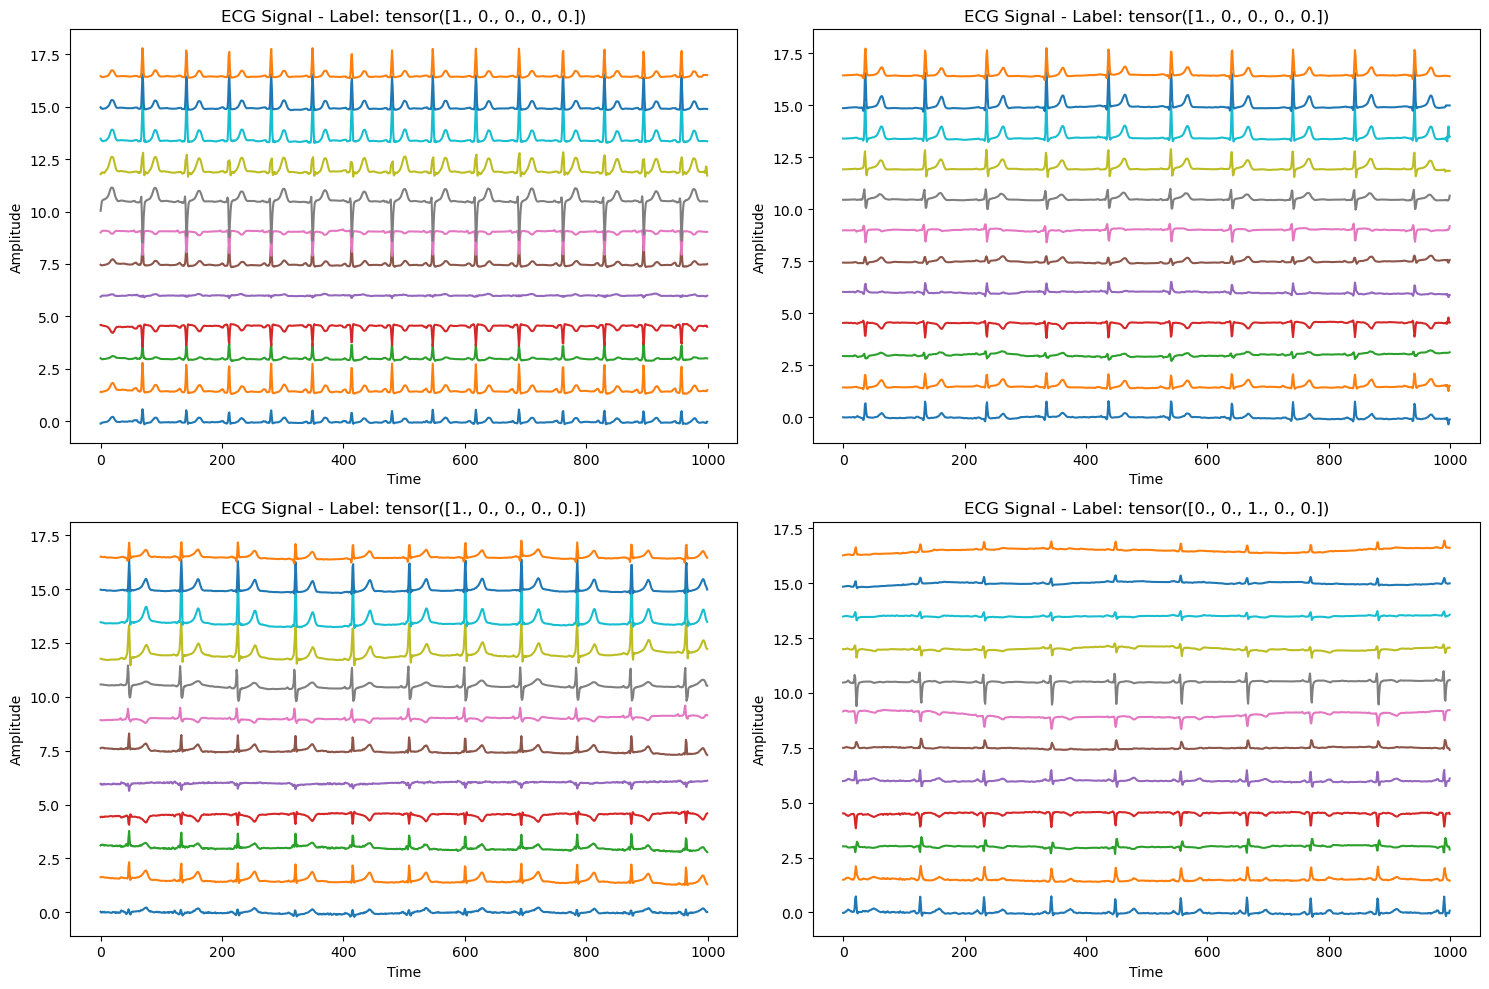

Sample 0: NORM
Sample 1: NORM
Sample 2: NORM
Sample 3: MI


In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg(signal, label, ax):
    for i in range(signal.shape[1]):  
        ax.plot(signal[:,i] + i * 1.5, label=f'Lead {i+1}') 
    ax.set_title(f'ECG Signal - Label: {label}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

dataiter = iter(trainloader)
signals, labels = next(dataiter)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
for idx, ax in enumerate(axes.flat):
    plot_ecg(signals[idx], labels[idx], ax)

plt.tight_layout()  
plt.show()

for j in range(4):
    class_names = [classes[k] for k in range(labels.shape[1]) if labels[j, k] == 1]
    print(f'Sample {j}: {" ".join(class_names)}')

In [77]:
signals = signals.transpose(1, 2)
signals = signals.to('cuda', non_blocking=True)
labels = labels.to('cuda', non_blocking=True)
        
print(signals.shape)

outputs = model(signals)  
pred_labels = torch.sigmoid(outputs) > 0.5

torch.Size([4, 12, 1000])


In [78]:
print(pred_labels)

tensor([[ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [False, False,  True, False, False]], device='cuda:0')


In [79]:
for j in range(4):
    real_class_names = [classes[k] for k in range(labels.shape[1]) if labels[j, k] == 1]
    pred_class_names = [classes[k] for k in range(pred_labels.shape[1]) if pred_labels[j, k] == 1]
    print(f'Sample {j}: Real: {" ".join(real_class_names)} | Predicted: {" ".join(pred_class_names)}')

Sample 0: Real: NORM | Predicted: NORM
Sample 1: Real: NORM | Predicted: NORM
Sample 2: Real: NORM | Predicted: NORM
Sample 3: Real: MI | Predicted: MI


In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
X.shape

(21799, 1000, 12)

In [34]:
batch_size = 256
num_input_channels = 12
num_timepoints = 1000
x = torch.randn(batch_size, num_input_channels, num_timepoints)
print (x.shape)

num_output_channels = 24
kernel_size = 3
stride = 1
padding = 1

torch.Size([256, 12, 1000])


In [35]:
from torch.utils.checkpoint import checkpoint

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(num_input_channels, num_output_channels, kernel_size, stride, padding, padding_mode='zeros'), # first layer
            nn.BatchNorm1d(num_output_channels),
            nn.ReLU(),
            nn.Conv1d(num_output_channels, 2*num_output_channels, kernel_size, stride, padding, padding_mode='zeros'), # second layer
            nn.BatchNorm1d(2*num_output_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(2*num_output_channels, 4*num_output_channels, kernel_size, stride, padding, padding_mode='zeros'),
            nn.BatchNorm1d(4*num_output_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(24000, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 5)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [36]:
class MultiLabelSoftMarginLoss(nn.Module):
    def __init__(self, label_smoothing=0.0, reduction='mean'):
        super(MultiLabelSoftMarginLoss, self).__init__()
        assert 0 <= label_smoothing < 1, "label_smoothing value must be between 0 and 1."
        self.label_smoothing = label_smoothing
        self.reduction = reduction
        self.multi_label_soft_margin = nn.MultiLabelSoftMarginLoss(reduction=reduction)

    def forward(self, input, target):
        if self.label_smoothing > 0:
            # Calculate smoothed labels
            num_classes = target.size(1)  # Assumes target is [batch_size, num_classes]
            positive_smoothed_labels = 1.0 - self.label_smoothing
            negative_smoothed_labels = self.label_smoothing / (num_classes - 1)
            smoothed_target = target * positive_smoothed_labels + (1 - target) * negative_smoothed_labels
            target = smoothed_target

        loss = self.multi_label_soft_margin(input, target)
        return loss

In [37]:
model = MLP()
y = model(x)
print(y.shape)

import torch.optim as optim
model = model.cuda()
model = torch.compile(model)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

torch.cuda.empty_cache()

for epoch in range(20):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.transpose(1, 2)
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i + 1) % 2000 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

torch.Size([256, 5])
[1,  2000] loss: 0.558
[1,  4000] loss: 0.517
[2,  2000] loss: 0.486
[2,  4000] loss: 0.483
[3,  2000] loss: 0.456
[3,  4000] loss: 0.457
[4,  2000] loss: 0.437
[4,  4000] loss: 0.439
[5,  2000] loss: 0.420
[5,  4000] loss: 0.423
[6,  2000] loss: 0.412
[6,  4000] loss: 0.410
[7,  2000] loss: 0.393
[7,  4000] loss: 0.397
[8,  2000] loss: 0.389
[8,  4000] loss: 0.386
[9,  2000] loss: 0.379
[9,  4000] loss: 0.378
[10,  2000] loss: 0.370
[10,  4000] loss: 0.367
[11,  2000] loss: 0.361
[11,  4000] loss: 0.357
[12,  2000] loss: 0.354
[12,  4000] loss: 0.356
[13,  2000] loss: 0.345
[13,  4000] loss: 0.351
[14,  2000] loss: 0.337
[14,  4000] loss: 0.340
[15,  2000] loss: 0.333
[15,  4000] loss: 0.334
[16,  2000] loss: 0.327
[16,  4000] loss: 0.328
[17,  2000] loss: 0.320
[17,  4000] loss: 0.329
[18,  2000] loss: 0.316
[18,  4000] loss: 0.320
[19,  2000] loss: 0.312
[19,  4000] loss: 0.313
[20,  2000] loss: 0.308
[20,  4000] loss: 0.309
Finished Training


In [38]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.transpose(1, 2)
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)

        # Calculate outputs by running images through the network
        outputs = model(inputs)

        # Apply a threshold to determine the predicted labels
        predicted = torch.sigmoid(outputs).round()   # Adjust threshold as needed

        # Calculate correct predictions
        correct += (predicted == labels).sum()
            
        total += labels.numel()  # Total number of labels

print(f"Total: {total}, Correct: {correct}")
print(f'Accuracy of the network: {100 * correct / total:.2f} %')


Total: 10790, Correct: 8940
Accuracy of the network: 82.85 %


In [39]:
# Assuming 'classes' is a list where the index corresponds to the label, e.g., classes = ['class0', 'class1', 'class2', 'class3', 'class4']
classes = ['NORM', 'CD', 'MI', 'HYP', 'STTC']

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again, no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.transpose(1, 2)  # Ensure the correct input shape for your model
        inputs = inputs.to('cuda', non_blocking=True)
        labels = labels.to('cuda', non_blocking=True)

        outputs = model(inputs)
        predicted = torch.sigmoid(outputs).round()  # Convert outputs to binary predictions

        # Collect the correct predictions for each class
        for i in range(len(classes)):
            correct_pred[classes[i]] += ((predicted[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
            total_pred[classes[i]] += (labels[:, i] == 1).sum().item()

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:  # To avoid division by zero
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class {classname} is {accuracy:.1f} %')
    else:
        print(f'No samples for class {classname}')


Accuracy for class NORM is 83.4 %
Accuracy for class CD is 43.9 %
Accuracy for class MI is 41.4 %
Accuracy for class HYP is 18.9 %
Accuracy for class STTC is 48.3 %
